In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
adata = sc.read(os.path.join(datadir, "anca_samples_annotated_v2.h5ad"))

In [3]:
adata.obs["cluster_annot"].replace({"Inflamed interstitial": "Inflamed",
                                   "Inflamed glomerular": "Inflamed"}, inplace=True)

In [4]:
import pickle
pickle_path = os.path.join(datadir, "filtered_added.pkl")
with open(pickle_path, "rb") as handle:
    newdict = pickle.load(handle)

In [5]:
targets = {}
# remove immunostimulants
for key in newdict['L']:
    if key not in newdict["L03"]:
        targets[key] = newdict['L'][key]
    

In [6]:
len(list(targets.keys()))

277

In [7]:
adata.X.max()

7.8426557

In [8]:
import drug2cell as d2c
d2c.score(adata, targets=targets, nested=False, use_raw=False)

In [9]:
sc.tl.rank_genes_groups(adata.uns['drug2cell'], method="wilcoxon", groupby="cluster_annot", pts=True, use_raw=False, key_added="wilcoxon_drug")

In [10]:
log2fc = 0.25
pval = 0.05

In [11]:
dfs = {}
for clst in adata.obs["cluster_annot"].unique(): #_merge
    dfs[clst] = sc.get.rank_genes_groups_df(adata.uns["drug2cell"], group=clst, pval_cutoff=pval,
                                            log2fc_min=log2fc,
                                            key="wilcoxon_drug").set_index("names")
    spec = pd.read_csv(os.path.join(datadir, "drug_scores_single_cell_EMRM.csv"), index_col=0)[["scores"]]
    spec.columns=["spec"]
    
    common = list(set(dfs[clst].index.tolist())&set(spec.index.tolist()))
    dfs[clst], spec = dfs[clst].loc[common], spec.loc[common]
    dfs[clst]["spec"] = spec.loc[dfs[clst].index]["spec"].tolist()

In [12]:
tmp = dfs["Inflamed"].copy()
tmp = tmp.sort_values(by="spec", ascending=False)

tmp.rename(columns={"scores": "ST score (inflamed glomerular and interstsitial)",
                                "spec": "SC score (CD4 and CD8 T EM/RM)"}, inplace=True)

# tmp.to_csv(os.path.join(datadir, "drugs.csv"))

In [13]:
pct_group = 0.75
pct_ref = 0.75

for clst in ["Inflamed"]: 
    dfs[clst] = dfs[clst][dfs[clst]["pct_nz_group"]>=pct_group]
    dfs[clst] = dfs[clst][dfs[clst]["pct_nz_reference"]<=pct_ref]

In [14]:
dfs["Inflamed"] = dfs["Inflamed"].sort_values(by="spec", ascending=False)

In [15]:
df_int = dfs["Inflamed"].copy()
df_int = df_int[["scores", "spec"]]
df_int.columns = ["ST", "SC"]

In [16]:
df = df_int.copy()

In [17]:
import matplotlib as mpl

In [18]:
colorby="ST"
group="Inflamed\nglomerular and interstitial"
x="SC"
df.loc["dummy", "ST"] = 2
df.loc["dummy_1", "ST"] = 10

In [19]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [20]:
df["names"] = df.index.tolist()

In [21]:
# df.loc[df["ST"]>7, "ST"] = 7

In [22]:
sc.set_figure_params(dpi=100)
sns.set(style="ticks", font_scale=1.2)
plt.rcParams["font.family"] = ["Inter"]

In [23]:
df

,ST,SC,names
names,,,
USTEKINUMAB,5.646037,110.415990,USTEKINUMAB
BRENTUXIMAB VEDOTIN,8.767522,68.320280,BRENTUXIMAB VEDOTIN
ENFORTUMAB VEDOTIN,8.209852,68.294050,ENFORTUMAB VEDOTIN
VINFLUNINE,8.522844,68.294050,VINFLUNINE
BELANTAMAB MAFODOTIN,8.526117,68.280624,BELANTAMAB MAFODOTIN
POLATUZUMAB VEDOTIN,8.580985,67.322130,POLATUZUMAB VEDOTIN
TOCILIZUMAB,8.099488,62.307686,TOCILIZUMAB
dummy,2.000000,NaN,dummy
dummy_1,10.000000,NaN,dummy_1


In [23]:
df

,ST,SC,names
names,,,
USTEKINUMAB,5.646037,110.415990,USTEKINUMAB
BRENTUXIMAB VEDOTIN,8.767522,68.320280,BRENTUXIMAB VEDOTIN
ENFORTUMAB VEDOTIN,8.209852,68.294050,ENFORTUMAB VEDOTIN
VINFLUNINE,8.522844,68.294050,VINFLUNINE
BELANTAMAB MAFODOTIN,8.526117,68.280624,BELANTAMAB MAFODOTIN
POLATUZUMAB VEDOTIN,8.580985,67.322130,POLATUZUMAB VEDOTIN
TOCILIZUMAB,8.099488,62.307686,TOCILIZUMAB
dummy,2.000000,NaN,dummy
dummy_1,10.000000,NaN,dummy_1


/tmp/ipykernel_1718/3633753967.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(plot, fraction=1, aspect=20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


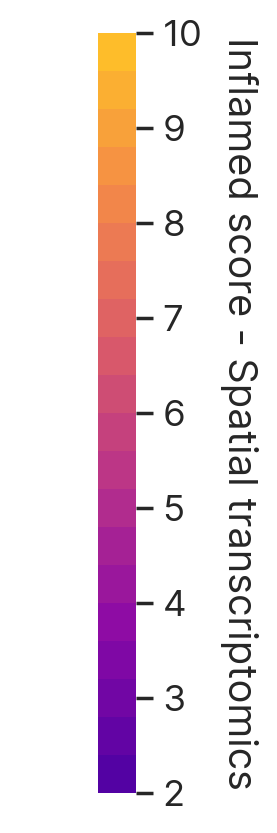

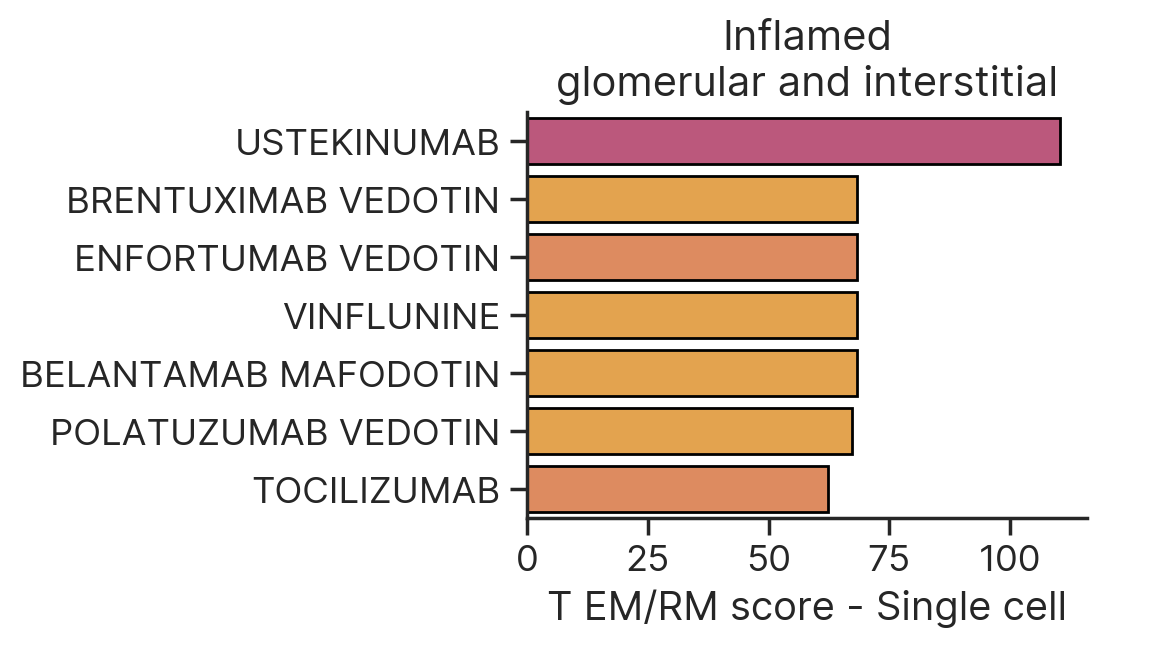

In [24]:
n = 20
cmap = "plasma"
plt.figure(figsize=(10,5))

cmp = mpl.colors.LinearSegmentedColormap.from_list('colorbar', sns.color_palette(cmap), N=n)
plot = plt.scatter(df.iloc[0:n][colorby], df.iloc[0:n][colorby], c=df.iloc[0:n][colorby], cmap=cmp)
plt.clf()
cbar = plt.colorbar(plot, fraction=1, aspect=20)
cbar.outline.set_linewidth(0.)
# cbar.set_label('T EM/RM score - single cell', rotation=270, labelpad=20)
cbar.set_label('Inflamed score - Spatial transcriptomics', rotation=270, labelpad=20)
plt.axis('off')

# plt.savefig(os.path.join(figdir, f"score_scale_{group}.pdf"), bbox_inches="tight")

pal = sns.color_palette("Blues_d", len(adata))

g=sns.catplot(data=df.iloc[0:-2], x=x, y="names",
                kind="bar", edgecolor="black", palette=colors_from_values(df.iloc[0:n][colorby], cmap), #edgecolors="black",
                height=3, aspect=4/2, sharex=False) # col="group", 

for ax in g.axes[0]:
    # ax.set_xlabel("- Log"r"$_{10}$"+" adj. "+"P"+"-value")
    # ax.set_xlabel("Log fold change")
    # ax.set_xlabel("drug score")
    ax.set_xlabel("T EM/RM score - Single cell")
    ax.set_ylabel("")
    ax.set_title(group, fontsize=15)
    # ax.set_xlim(0,80)
    # if ax.get_title()=="Abnormal glom.":
    #     ax.set_xlim(0,30)
    # else:
    #     ax.set_xlim(0,130)
    

plt.legend(frameon=False, bbox_to_anchor=(1,1))

# plt.savefig(os.path.join(figdir, f"drug_scores_{group}.pdf"), bbox_inches="tight")
plt.show()